# Visualization of the multiscale splitting
This script presents the multiscale splitting and the corrected basis functions that are mandatory for the LOD method. The multiscale splitting is the main idea for the method. Here, we split the space $V$ into the kernel and the image of an interpolation operator $I_H$ and yield

$$
V= V_H + V^{\text{f}},
$$

where $V_H$ denotes the coarse FEM space and $V^{\text{f}} = \{ v \in V \,|\, I_H(v)=0 \}$. With the finescale projection operator $\mathcal{Q}$ that maps from $V$ to $V^{\text{f}}$, the LOD space is defined by 

$$
V^{\text{LOD}} = V_H - \mathcal{Q} V_H.
$$

For more details on the theory and the localization, we refer to the thesis. 

In [1]:
import os
import sys
import numpy as np
import scipy.sparse as sparse

%matplotlib notebook
import matplotlib.pyplot as plt
from visualize import drawCoefficient, d3plotter

from gridlod import interp, coef, util, fem, world, linalg, femsolver
from gridlod.world import World
import femsolverCoarse
import pg_rand
import buildcoef2d

Once again, we make use of the 'buildcoef2d' class in order to construct an arbitrary function to visualize the splitting into coarse and finescale. The chosen constants are only examplarily. The used coefficient is visualized. 

<IPython.core.display.Javascript object>


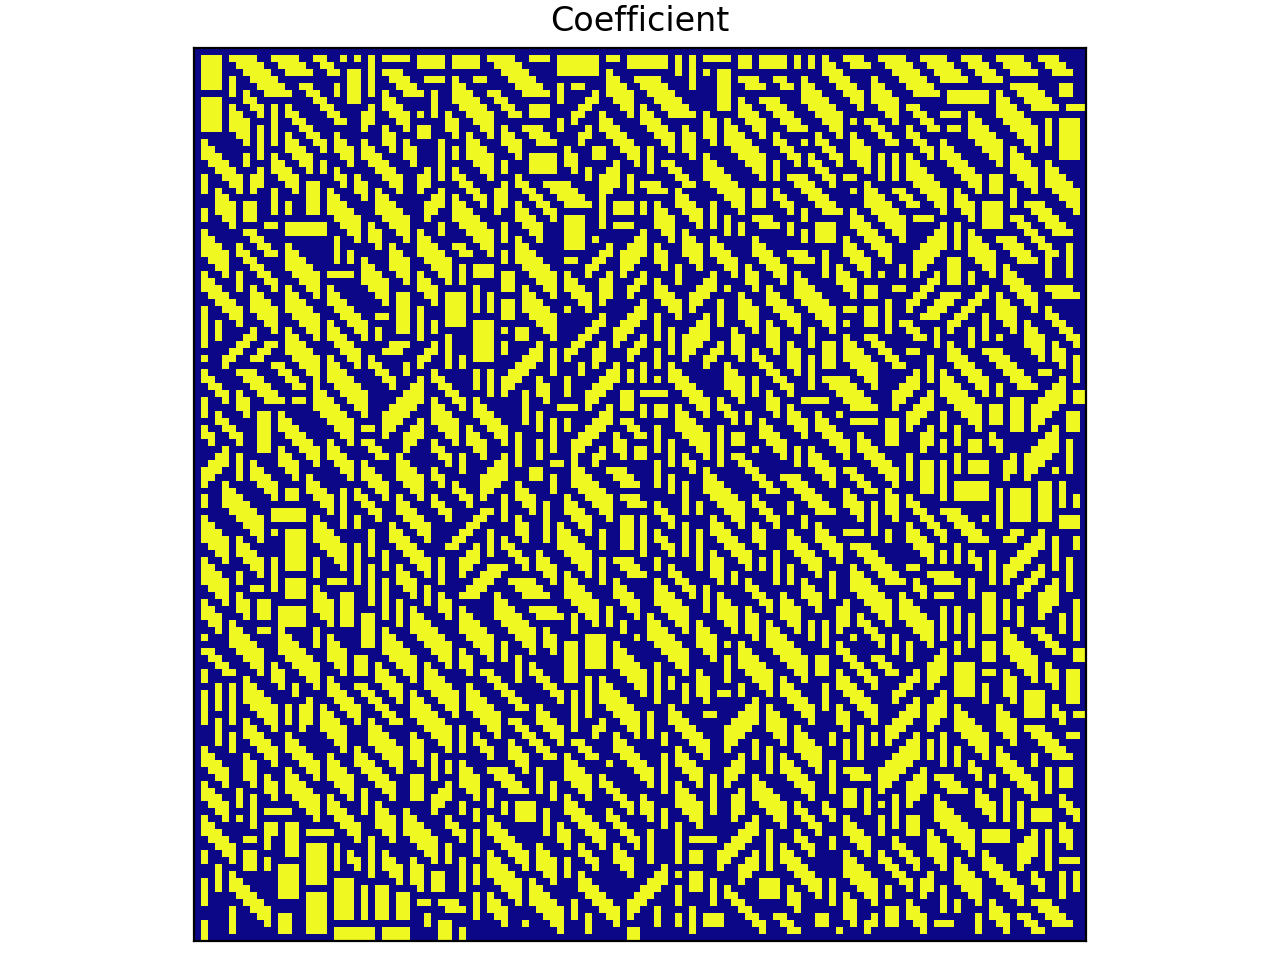

In [2]:
bg = 0.05   #background
val = 1     #values

#fine World
NWorldFine = np.array([128, 128])
NpFine = np.prod(NWorldFine+1)                                                                               

#coarse World
NWorldCoarse = np.array([8,8])
NpCoarse = np.prod(NWorldCoarse+1)

#ratio between Fine and Coarse
NCoarseElement = NWorldFine/NWorldCoarse

boundaryConditions = np.array([[0, 0],
                               [0, 0]])

world = World(NWorldCoarse, NCoarseElement, boundaryConditions)

#righthandside
f = np.ones(NpCoarse)

#coefficient
WormsUltCoefClass = buildcoef2d.Coefficient2d(NWorldFine, 
                                        bg                  = bg, 
                                        val                 = val, 
                                        length              = 1, 
                                        thick               = 1, 
                                        space               = 1, 
                                        probfactor          = 1, 
                                        right               = 1, 
                                        down                = 1, 
                                        diagr1              = 1, 
                                        diagr2              = 1, 
                                        diagl1              = 1, 
                                        diagl2              = 1, 
                                        LenSwitch           = [1,2,3,4,5,6], 
                                        thickSwitch         = [1,2,3], 
                                        equidistant         = None, 
                                        ChannelHorizontal   = None, 
                                        ChannelVertical     = None,
                                        BoundarySpace       = True)

A = WormsUltCoefClass.BuildCoefficient()
ABase = A.flatten()

plt.figure("OriginalCoefficient")
drawCoefficient(NWorldFine, ABase)
plt.title('Coefficient')
plt.show()

## Splitting
The ingredients are based on the 'gridlod' module. We compute the reference solution with the standard FEM and use it as the function $v \in V$. We always pick the $L^2$-projection interpolant and for the localization, we use a patch size of $k=4$. With the help of the functions of 'gridlod', we are able to identify the coarse mesh and determine the finescale part. We plot the result afterwards.  

<IPython.core.display.Javascript object>


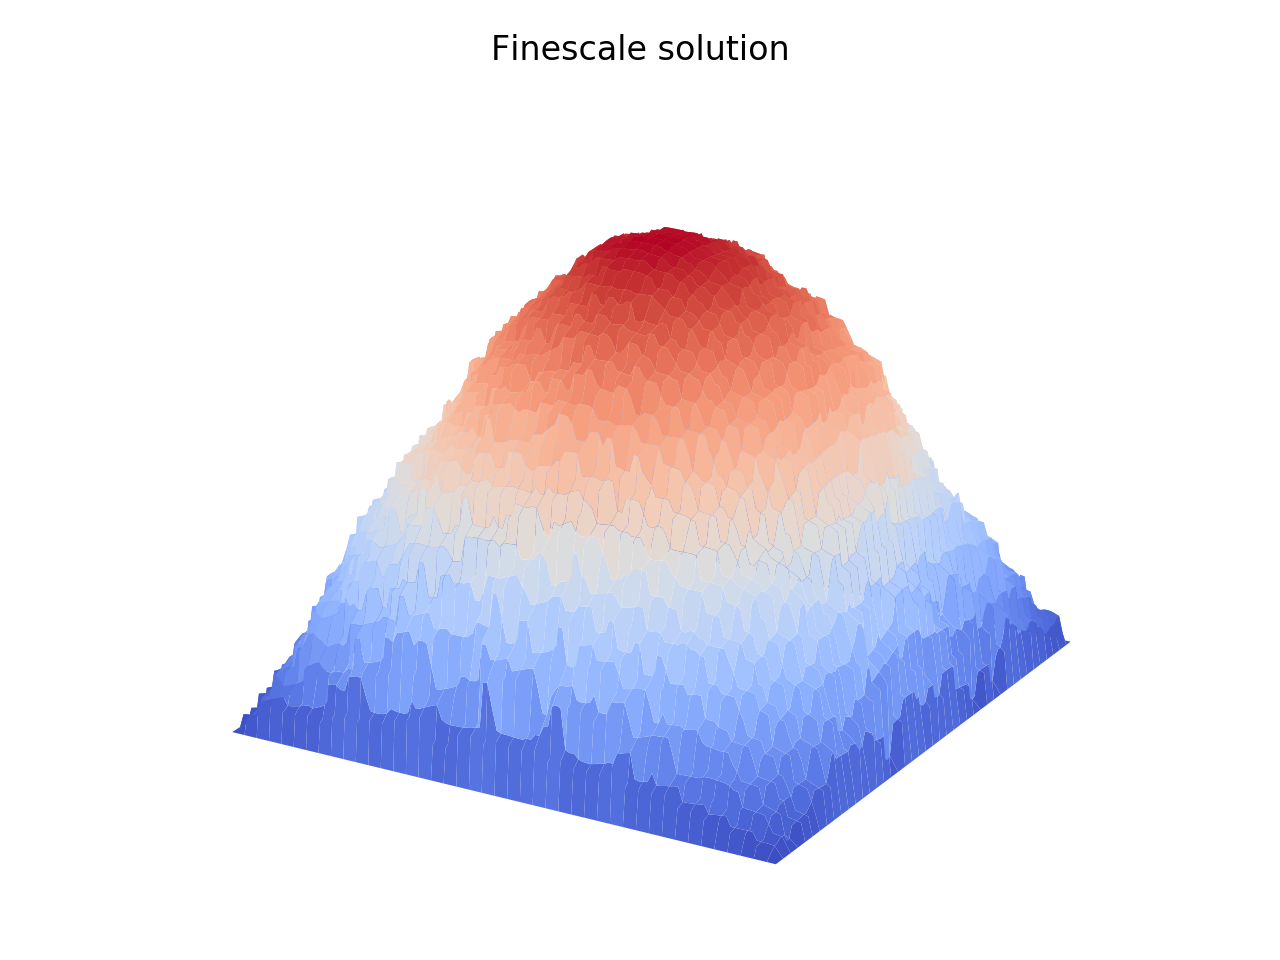

<IPython.core.display.Javascript object>


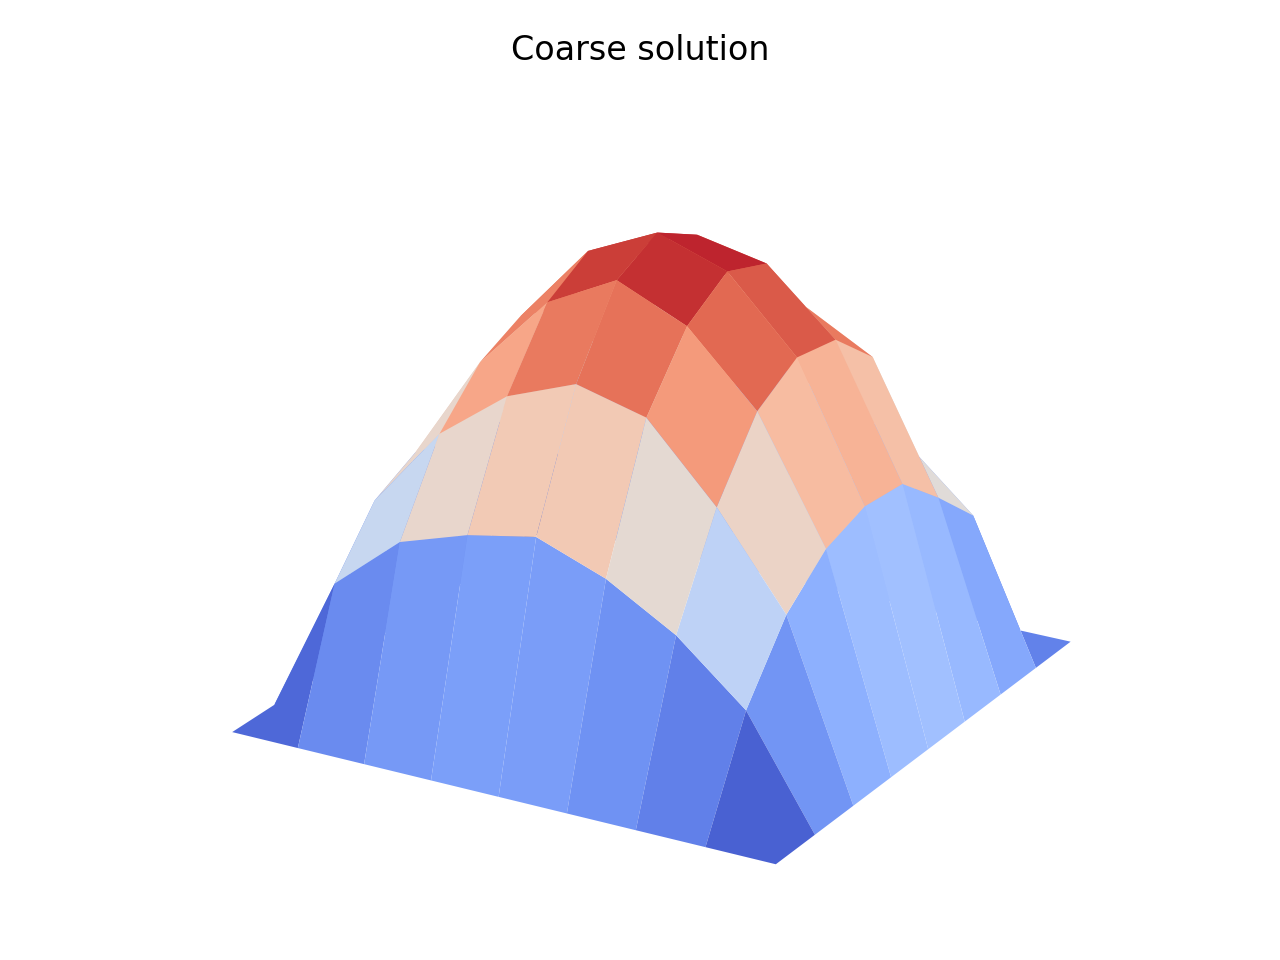

<IPython.core.display.Javascript object>


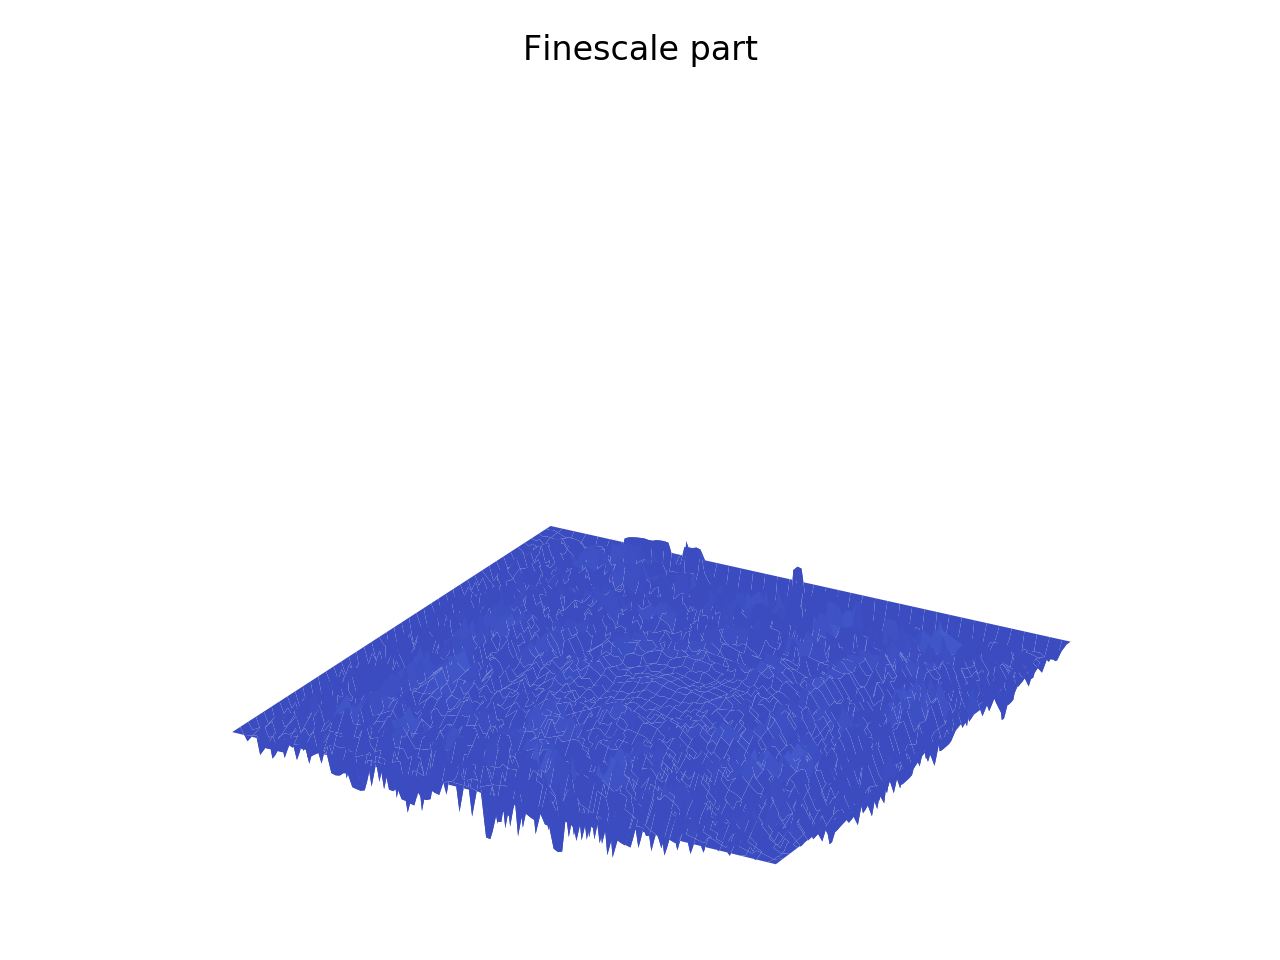

In [3]:
#fine-fem
f_fine = np.ones(NpFine)
uFineFem, AFine, MFine = femsolver.solveFine(world, ABase, f_fine, None, boundaryConditions)

#PGLOD
#interpolant
IPatchGenerator = lambda i, N: interp.L2ProjectionPatchMatrix(i, N, NWorldCoarse, NCoarseElement, boundaryConditions)

#Coefficient (need flatten form)
aCoef = coef.coefficientFine(NWorldCoarse, NCoarseElement, ABase)

k=4

pglod = pg_rand.VcPetrovGalerkinLOD(aCoef, world, k, IPatchGenerator, 1)
pglod.originCorrectors(clearFineQuantities=False)

KFull = pglod.assembleMsStiffnessMatrix()                                    
MFull = fem.assemblePatchMatrix(NWorldCoarse, world.MLocCoarse)
free  = util.interiorpIndexMap(NWorldCoarse)                                 

bFull = MFull*f

KFree = KFull[free][:,free]
bFree = bFull[free]

xFree = sparse.linalg.spsolve(KFree, bFree)

basis = fem.assembleProlongationMatrix(NWorldCoarse, NCoarseElement)
basisCorrectors = pglod.assembleBasisCorrectors()
modifiedBasis = basis - basisCorrectors

xFull = np.zeros(NpCoarse)
xFull[free] = xFree
uLodCoarse = xFull
uLodFine = modifiedBasis*xFull
diff = basis*uLodCoarse-uLodFine

# plot multiscale splitting
d3plotter(NWorldFine, uFineFem,boundary=[np.min(uFineFem),np.max(uFineFem)])
plt.title('Finescale solution')
d3plotter(NWorldCoarse, uLodCoarse, String='Coarse1', boundary=[np.min(uFineFem),np.max(uFineFem)])
plt.title('Coarse solution')
d3plotter(NWorldFine, diff, String='uf2',boundary=[np.min(uFineFem),np.max(uFineFem)], Blues= True)
plt.title('Finescale part')

plt.show()

## Basis functions

Furthermore, we have access to the standard basis, the correction and thus, to the modified basis. Therefore, those functions for a single element can be displayed easily. Here, we choose a particular element in the middle of the mesh.

<IPython.core.display.Javascript object>


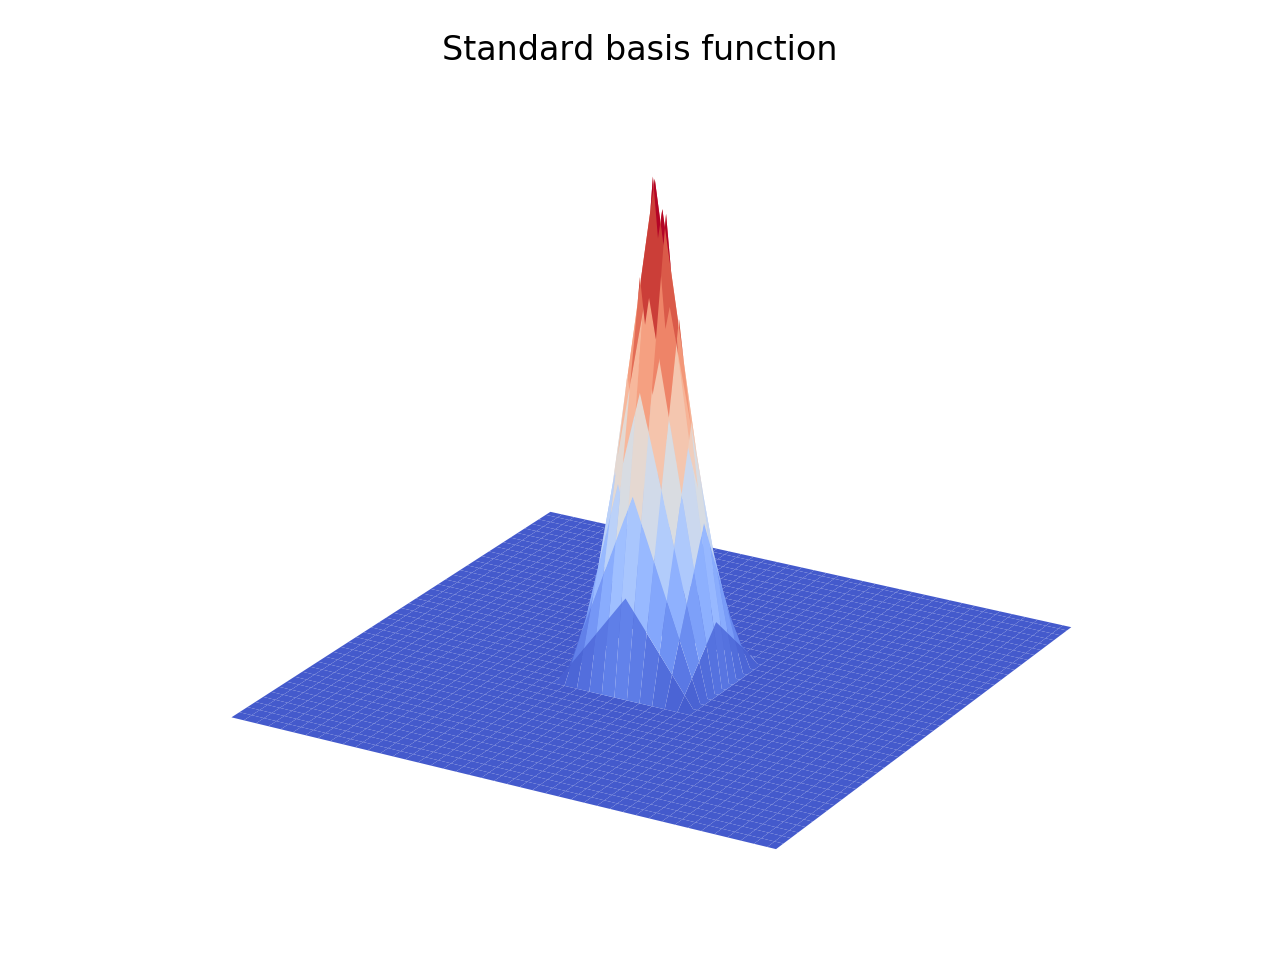

<IPython.core.display.Javascript object>


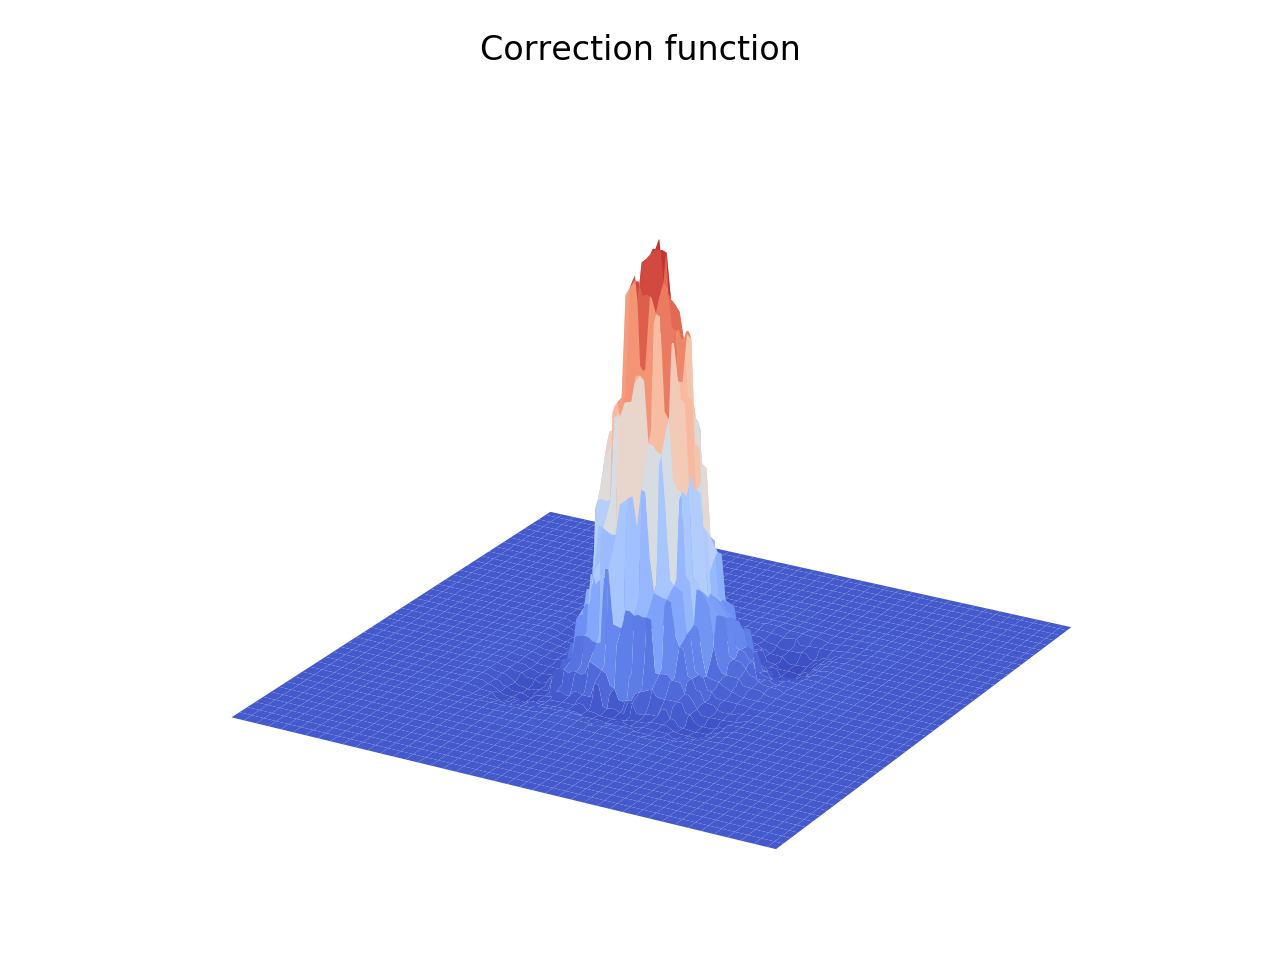

<IPython.core.display.Javascript object>


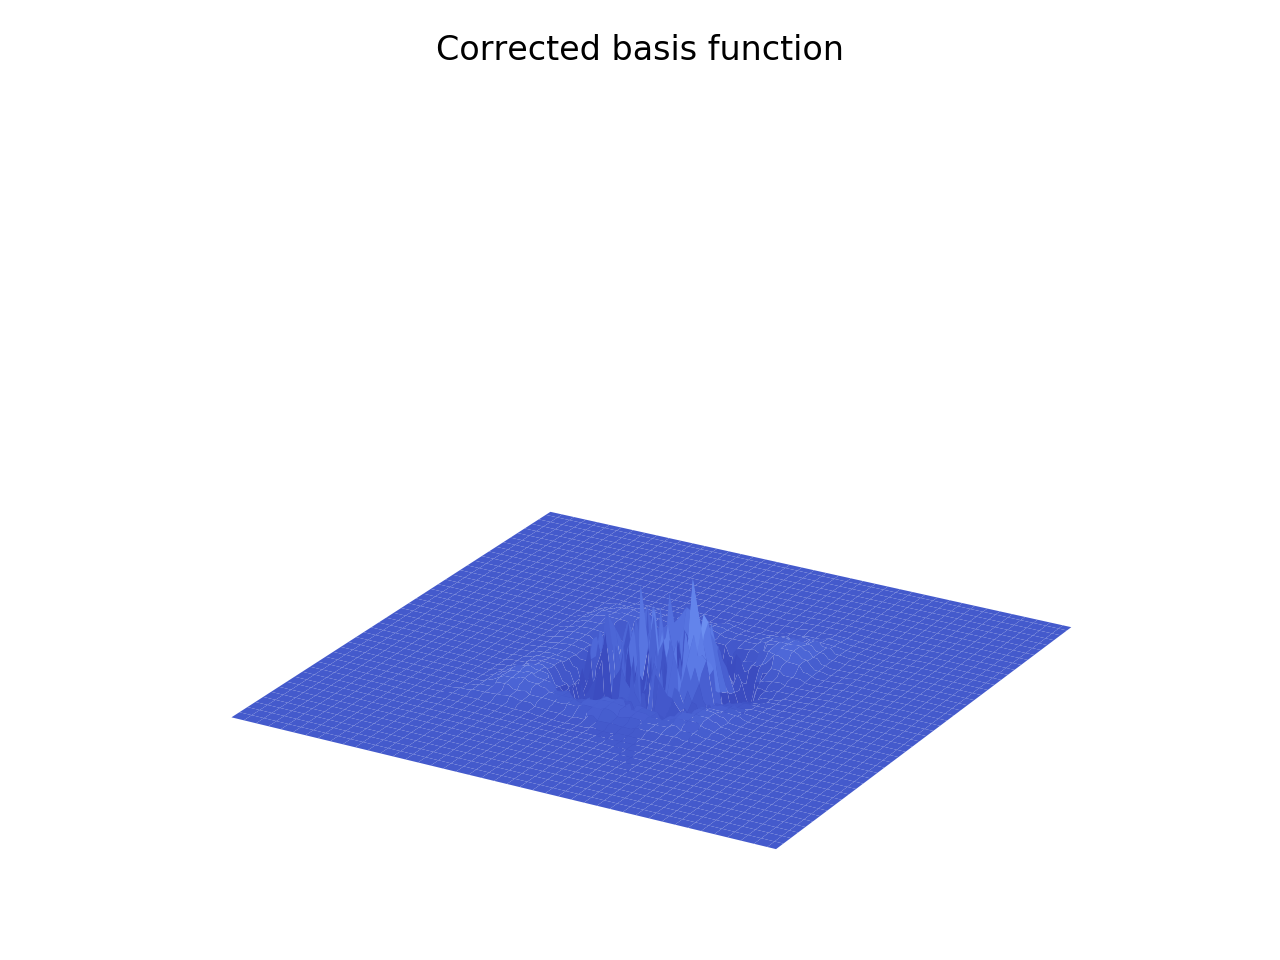

In [4]:
# plot for basis functions
schauen = np.zeros(NpCoarse)
schauen[40] = 1
schau = basis*schauen
schau1 = basisCorrectors*schauen
schau2 = modifiedBasis*schauen
zmax = np.max(schau2)
zmin = np.min(schau2)
d3plotter(NWorldFine, schau, '1', zmax=zmax, zmin=zmin, Blues=True)
plt.title('Standard basis function')
d3plotter(NWorldFine, schau2, '3', zmax=zmax, zmin=zmin)
plt.title('Correction function')
d3plotter(NWorldFine, schau1, '2', zmax=zmax, zmin=zmin, Blues=True)
plt.title('Corrected basis function')

plt.show()